# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

## Policy Gradient methods

As we saw previously in [section 2](#2.-Examine-the-State-and-Action-Spaces) what we're dealing with here is an envirornment with continuous observation space that consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm, and continues action space, a vector with 4 numbers, corresponding to torque applicable to two joints. Policy Gradient methods are the right fit for continuos action space.

I'll try to solve this environment using two PG algorithms, using the latest Actor-Critic methods:
1. [Advantage Actor Critic](https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f) or A2C
2. [Proximal Policy Optimization](https://medium.com/@jonathan_hui/rl-proximal-policy-optimization-ppo-explained-77f014ec3f12) or PPO, which will be built on top of A2C. [Paper](https://arxiv.org/abs/1707.06347)

I'll be also computing returns using [Generalized Advantage Estimation](https://danieltakeshi.github.io/2017/04/02/notes-on-the-generalized-advantage-estimation-paper/) or GAE. [Paper](https://arxiv.org/abs/1506.02438)

In [2]:
import numpy as np
from unityagents import UnityEnvironment

In [3]:
import torch
import torch.nn.functional as F
from torch.optim import RMSprop, Adam

from agent.a2c_agent import A2CAgent
from agent.ppo_agent import PPOAgent
from agent.config import Config
from agent.utils import EnvironmentAdapterForUnity

In [4]:
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
unity_envs = EnvironmentAdapterForUnity(env, brain_name)
config = Config()

In [6]:
config.seed = 0
config.num_agents = num_agents
config.envs = unity_envs
config.num_episodes = 1000
config.steps = 2000
config.state_size = state_size
config.action_size = action_size
config.activ_actor = F.relu
config.activ_critic = F.relu
# config.optim = Adam
config.optim_actor = Adam
config.optim_critic = Adam
# config.lr = 3e-4
config.lr_actor = 3e-4
config.lr_critic = 3e-4
# config.hidden_units = (64, 64)
config.hidden_actor = (512, 512)
config.hidden_critic = (512, 512)
config.grad_clip_actor = 5
config.grad_clip_critic = 5
config.gamma = 0.99
config.ppo_clip = 0.2
config.ppo_epochs = 10
config.ppo_batch_size = 32
config.ent_weight = 0.01
config.val_loss_weight = 1
config.use_gae = True
config.lamda = 0.95
config.env_solved = 30
config.times_solved = 100

In [7]:
agent = A2CAgent(config)

In [8]:
agent.summary()

A2C Agent:

Policy Network:
---------------
Actor(
  (layers): ModuleList(
    (0): Linear(in_features=33, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
)

Value Network:
--------------
Critic(
  (layers): ModuleList(
    (0): Linear(in_features=33, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [9]:
score = agent.train()

Episode 1	Policy loss: -0.064	Value loss: 0.032	Avg Score: 0.368
Best score so far: 0.368
Episode 2	Policy loss: -0.062	Value loss: 0.025	Avg Score: 0.481
Best score so far: 0.481
Episode 3	Policy loss: -0.082	Value loss: 0.032	Avg Score: 0.848
Best score so far: 0.848
Episode 5	Policy loss: -0.058	Value loss: 0.023	Avg Score: 0.904
Best score so far: 0.904
Episode 7	Policy loss: -0.070	Value loss: 0.041	Avg Score: 0.973
Best score so far: 0.973
Episode 17	Policy loss: -0.073	Value loss: 0.128	Avg Score: 0.974
Best score so far: 0.974
Episode 21	Policy loss: -0.065	Value loss: 0.106	Avg Score: 1.183
Best score so far: 1.183
Episode 35	Policy loss: -0.106	Value loss: 0.139	Avg Score: 1.220
Best score so far: 1.220
Episode 40	Policy loss: -0.065	Value loss: 0.098	Avg Score: 1.407
Best score so far: 1.407
Episode 42	Policy loss: -0.060	Value loss: 0.110	Avg Score: 1.416
Best score so far: 1.416
Episode 43	Policy loss: -0.066	Value loss: 0.126	Avg Score: 1.567
Best score so far: 1.567
Epis

No success. Avg score: 27.529
Episode 691	Policy loss: -0.112	Value loss: 0.101	Avg Score: 30.236
Running full evaluation...
No success. Avg score: 29.170
Episode 738	Policy loss: -0.123	Value loss: 0.103	Avg Score: 31.320
Best score so far: 31.320

Running full evaluation...
No success. Avg score: 29.291
Episode 747	Policy loss: -0.122	Value loss: 0.105	Avg Score: 30.040
Running full evaluation...
No success. Avg score: 29.686
Episode 755	Policy loss: -0.117	Value loss: 0.108	Avg Score: 30.118
Running full evaluation...
No success. Avg score: 29.613
Episode 756	Policy loss: -0.140	Value loss: 0.110	Avg Score: 30.500
Running full evaluation...
No success. Avg score: 29.647
Episode 757	Policy loss: -0.136	Value loss: 0.108	Avg Score: 30.433
Running full evaluation...
No success. Avg score: 29.699
Episode 763	Policy loss: -0.090	Value loss: 0.104	Avg Score: 30.407
Running full evaluation...
No success. Avg score: 29.808
Episode 766	Policy loss: -0.114	Value loss: 0.119	Avg Score: 31.039


In [10]:
np.save('a2c_scores.npy', score)

In [7]:
agent = PPOAgent(config)

In [8]:
agent.summary()

PPO Agent:

Policy Network:
---------------
Actor(
  (layers): ModuleList(
    (0): Linear(in_features=33, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
)

Value Network:
--------------
Critic(
  (layers): ModuleList(
    (0): Linear(in_features=33, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [9]:
score = agent.train()

Episode 1	Policy loss: -0.004	Value loss: 0.003	Avg Score: 0.124
Best score so far: 0.124
Episode 2	Policy loss: 0.081	Value loss: 0.000	Avg Score: 0.213
Best score so far: 0.213
Episode 3	Policy loss: -0.304	Value loss: 0.000	Avg Score: 0.457
Best score so far: 0.457
Episode 7	Policy loss: 0.161	Value loss: 0.001	Avg Score: 0.9699
Best score so far: 0.969
Episode 8	Policy loss: -0.188	Value loss: 0.001	Avg Score: 1.040
Best score so far: 1.040
Episode 10	Policy loss: -0.130	Value loss: 0.002	Avg Score: 1.049
Best score so far: 1.049
Episode 11	Policy loss: 0.250	Value loss: 0.001	Avg Score: 1.207
Best score so far: 1.207
Episode 12	Policy loss: -0.021	Value loss: 0.002	Avg Score: 1.527
Best score so far: 1.527
Episode 13	Policy loss: -0.060	Value loss: 0.003	Avg Score: 1.635
Best score so far: 1.635
Episode 14	Policy loss: 0.310	Value loss: 0.002	Avg Score: 2.221
Best score so far: 2.221
Episode 16	Policy loss: -0.124	Value loss: 0.002	Avg Score: 2.485
Best score so far: 2.485
Episode

In [10]:
np.save('ppo_scores.npy', score)

In [11]:
from agent.utils import plot_scores

In [12]:
a2c_scores = np.load('a2c_scores.npy')

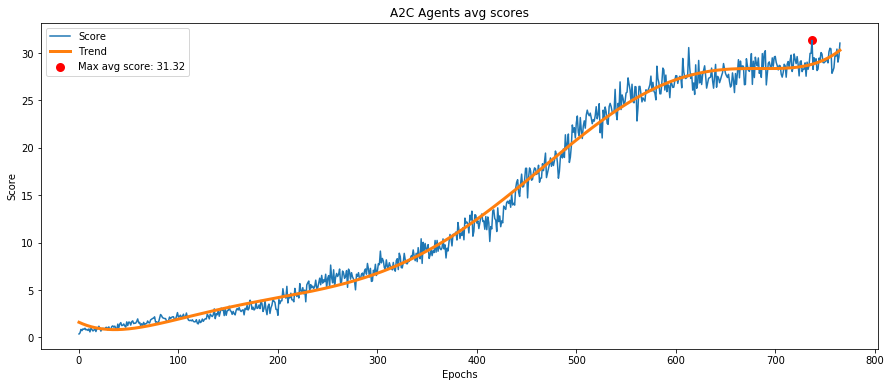

In [14]:
plot_scores(a2c_scores, title='A2C Agents avg scores', polyfit_deg=6)

In [15]:
ppo_scores = np.load('ppo_scores.npy')

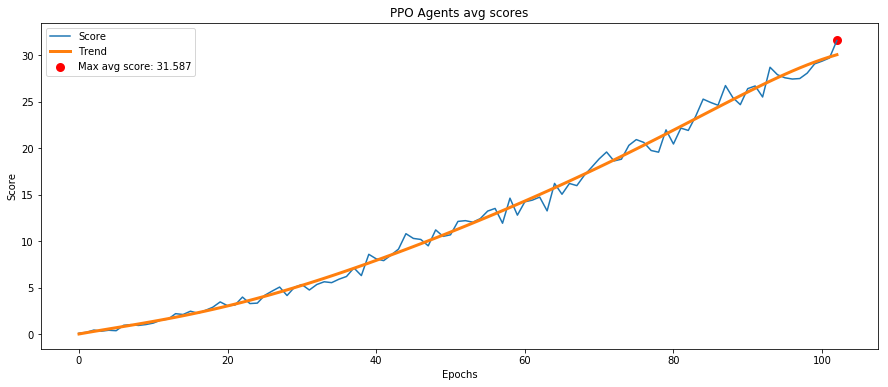

In [16]:
plot_scores(ppo_scores, title='PPO Agents avg scores', polyfit_deg=6)